In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import time

In [6]:
exe_dir = "/home/sreekumar/DATA_ANALYSIS_LAB/code"
data_dir = "/home/sreekumar/DATA_ANALYSIS_LAB/solutions/Exercise_3"

In [3]:
"""
Usage: ./generate_source  [-h] [-o <file>] [-s <float>] [-d <float>] [-N <int>] [-f <float>] [-p <float>]
                          [-a <float>] [-r <int>]
  -o, --output=<file>       output file
  -s, --sigma=<float>       standard deviation sigma
  -d, --deltaT=<float>      delta T betwean measurements
  -N, --length=<int>        number of elements
  -f, --freq=<float>        frequency
  -p, --phase=<float>       phase
  -a, --amplitude=<float>   signal amplitude
  -r, --random=<int>        if set to 1, generate random signal
  -h, --help                print this help and exit
"""      

def generate_source(outputFile=None, sigma=0, f=0, A=0, delta_T=None, N=10000, phi=0, r=0):
    if delta_T == None : 
        delta_T = 1/N
       
    dataPath = os.path.join(data_dir, outputFile)
    exe_path = os.path.join(exe_dir, 'generate_source')
    cmd_str = f"{exe_path} -o {dataPath} -s {sigma} -d {delta_T} -N {N} -f {f} -p {phi} -a {A} -r {r}"
    
    #print(cmd_str)
    
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)
    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    if out:
        print('The process has an output:', out.decode())

    return

In [4]:
"""
Usage: ./prober  [-h] [-i <file>] [-o <file>] [-f <float>] [-p <float>] [-t <file>] [-m <int>]
  -i, --input=<file>        input file
  -o, --output=<file>       output file
  -f, --freq=<float>        frequency
  -p, --phase=<float>       phase
  -h, --help                print this help and exit
  -t, --templatebank=<file> template bank file
  -m, --method=<int>        select method to analyze signal 1, 2 or 3
"""

def prober(inputFile, f=0, outputFile=None, phi=0, template=None, mod=0):
    
    exe_path = os.path.join(exe_dir, 'prober')
    cmd_str = f"{exe_path} -i {data_dir}/{inputFile} -o {data_dir}/{outputFile} -m {mod}"
    if template:
        cmd_str += f" -t {data_dir}/{template} "
    else:
        cmd_str += f" -f {f} -p {phi}"
        
    #print(cmd_str)
        
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)
    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    #if out:
        #print('The process has an output:', out.decode())
        
    if out:
        if template:
            print('The process has an output:', out.decode())
        else:
            with open(f"{data_dir}/output_S{mod}.txt", "w") as file:
                print('The process has an output:', out.decode())
                file.write(out.decode())
                #return f"output_S{mod}.txt"
    if mod == 3:
        if template:
            print(cmd_str)
        else:
            data = np.loadtxt(f"{data_dir}/{outputFile}")
            with open(f"{data_dir}/output_S{mod}.txt", "w") as file:
                file.write("{0: .1f}".format(data[f][0]) + " {0:.1f}".format(data[f][1]) + " {0:.1f}".format(data[f][2]))
                #file.write("{0}\n".format(data[f]))
                #return f"output_S{mod}.txt"
    
    return f"output_S{mod}.txt"

In [24]:
"""
data_set = {
    1: {
        'sigma': 0.0,
        'A': 1,
        'f': 30,
        'delta_T': 0.0001,
        'filename': "data_01.csv",
        'title': "-s 0 -a 1",
    },
    2: {
        'sigma': 0.5,
        'A': 1,
        'f': 30,
        'delta_T': 0.0001,
        'filename': "data_02.csv",
        'title': "-s 0.5 -a 1",
    },
    3: {
        'sigma': 5,
        'A': 1,
        'f': 30,
        'delta_T': 0.0001,
        'filename': "data_03.csv",
        'title': "-s 5 -a 1",
    },
    4: {
        'sigma': 10,
        'A': 1,
        'f': 30,
        'delta_T': 0.0001,
        'filename': "data_04.csv",
        'title': "-s 10 -a 1",
    },
    5 : {
        'sigma': 10,
        'A': 0,
        'f': 30,
        'delta_T': 0.0001,
        'filename': "data_05.csv",
        'title': "-s 10 -a 0",
    }
}

for key, value in data_set.items():
    generate_source(value.get('filename'), sigma=value.get('sigma'), A=value.get('A'), f=value.get('f'), delta_T=value.get('delta_T'))
"""
    
data_files = []
nf = 101
frq = np.linspace(0.5, 100.5, nf)
for n in range(nf):
    data_files.append(generate_source(f"data_0{n}.csv",sigma=0.25, A=1, f=frq[n]))
with open(f"{data_dir}/true_freq.csv", "w") as file:
    for i in range(nf):
        file.write("{0}\n".format(frq[i]))

In [6]:
#Define a function to calculate the Mismatch
def mismatch(iFile, resultsFile, mode, freq=0, p=0, nfrq=0, nphi=0):
    #Create a template bank
    if nphi == 0:
        frq = np.linspace(0.01, 100.0, nfrq)
        with open(f"{data_dir}/temp_bank_{nfrq}.csv", "w") as file:
            for i in range(nfrq):
                file.write("{0} {1}\n".format(frq[i],0))
        tbank = f"temp_bank_{nfrq}.csv"
    else:
        frq = np.linspace(0.01, 100.0, nfrq)
        ph = np.linspace(0, 2*np.pi, nphi)
        with open(f"{data_dir}/temp_bank_{nfrq}_{nphi}.csv", "w") as file:
            for i in range(nfrq):
                for j in range(nphi):
                    file.write("{0} {1}\n".format(frq[i], ph[j]))
        tbank = f"temp_bank_{nfrq}_{nphi}.csv"
    
    
    OFile_1 = prober(inputFile=iFile, f=freq, outputFile=resultsFile, phi=p, mod=mode)
    prober(inputFile=iFile, outputFile=resultsFile, template=tbank, mod=mode)
    
        
    if mode == 2:
        data1 = np.loadtxt(os.path.join(data_dir, OFile_1))
        s_true = data1[2]
        print("Minimum Value at f: ",s_true)
        data2 = np.loadtxt(os.path.join(data_dir, resultsFile))
        s = np.where(data2[:,2] == np.min(data2[:,2]))
        s_best = data2[:,2][s][0]
        print("Minimum value at best f: ",s_best)
        M = 1 - abs(float(s_true)-float(s_best)/float(s_true))
    else:
        data1 = np.loadtxt(os.path.join(data_dir, OFile_1))
        s_true = data1[2]
        print("Maximum Value at f : ",s_true)
        data2 = np.loadtxt(os.path.join(data_dir, resultsFile))
        s = np.where(data2[:,2] == np.max(data2[:,2]))
        s_best = data2[:,2][s][0]
        print("Maximum value at best f: ",s_best)
        M = 1 - float(s_best)/float(s_true)
    
    print("Mismatch: ",M)
    print("\n")
    
    #if nphi == 0:
        #return f"{freq} {M}"
    #else:
        #return f"{freq} {p} {M}"
        
    return M

In [25]:
# a = 1, s = 0, f = 30, p = 0
values = []
for n in range(nf):
    values.append(mismatch(f"data_0{n}.csv", resultsFile=f"results_0{n}_S1.csv", mode=1, freq=frq[n], p=0, nfrq=300, nphi=0))
#os.system(f"echo '{data}' >> {data_dir}/values_S1.csv")


The process has an output: 0.5 0 0.50087

Maximum Value at f :  0.50087
Maximum value at best f:  0.503118
Mismatch:  -0.004488190548445514


The process has an output: 1.5 0 0.499346

Maximum Value at f :  0.499346
Maximum value at best f:  0.450595
Mismatch:  0.09762969964713841


The process has an output: 2.5 0 0.500869

Maximum Value at f :  0.500869
Maximum value at best f:  0.44419
Mismatch:  0.11316132561607928


The process has an output: 3.5 0 0.497097

Maximum Value at f :  0.497097
Maximum value at best f:  0.439657
Mismatch:  0.11555088845838934


The process has an output: 4.5 0 0.499913

Maximum Value at f :  0.499913
Maximum value at best f:  0.443648
Mismatch:  0.11254958362755119


The process has an output: 5.5 0 0.499231

Maximum Value at f :  0.499231
Maximum value at best f:  0.441984
Mismatch:  0.11467036301832212


The process has an output: 6.5 0 0.50033

Maximum Value at f :  0.50033
Maximum value at best f:  0.446894
Mismatch:  0.10680151100273827


The proce

Maximum Value at f :  0.501869
Maximum value at best f:  0.49874
Mismatch:  0.006234694711169664


The process has an output: 58.5 0 0.498662

Maximum Value at f :  0.498662
Maximum value at best f:  0.495561
Mismatch:  0.006218641083539644


The process has an output: 59.5 0 0.500747

Maximum Value at f :  0.500747
Maximum value at best f:  0.496633
Mismatch:  0.008215725705795651


The process has an output: 60.5 0 0.500199

Maximum Value at f :  0.500199
Maximum value at best f:  0.494772
Mismatch:  0.010849681826632929


The process has an output: 61.5 0 0.49918

Maximum Value at f :  0.49918
Maximum value at best f:  0.49294
Mismatch:  0.012500500821347016


The process has an output: 62.5 0 0.500421

Maximum Value at f :  0.500421
Maximum value at best f:  0.49332
Mismatch:  0.014190051976236018


The process has an output: 63.5 0 0.499189

Maximum Value at f :  0.499189
Maximum value at best f:  0.491271
Mismatch:  0.015861727722365604


The process has an output: 64.5 0 0.49781

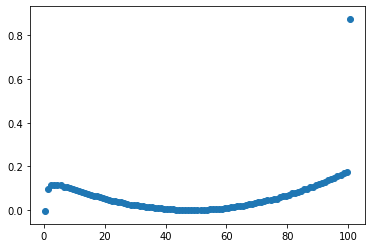

In [26]:
#print(values)
#data_values = np.loadtxt(f"{data_dir}/values_S1.csv")
plt.scatter(frq,values)
#plt.xlabel("nfrq")
#plt.ylabel("mismatch")

In [40]:
"""
generate_source(f"data_06.csv", sigma=5, A=0, f=30)
generate_source(f"data_07.csv", sigma=5, A=1, f=30)
prober(f"data_06.csv", f=30, outputFile="results_6_S1", phi=0, mod=1)
prober(f"data_07.csv", f=30, outputFile="results_7_S1", phi=0, mod=1)
"""
generate_source(f"data_06.csv", sigma=5, N=1000)
generate_source(f"data_07.csv", sigma=5, A=1, f=30, N=1000)
prober(f"data_06.csv", f=30, outputFile="results_6_S1", phi=0, mod=1)
prober(f"data_07.csv", f=30, outputFile="results_7_S1", phi=0, mod=1)

The process has an output: 30 0 -0.0703772

The process has an output: 30 0 0.581304



'output_S1.txt'

In [41]:
n = 1000
freq = np.linspace(0.01, 100.0, n)
with open(f"{data_dir}/temp_bank.csv", "w") as file:
    for i in range(n):
        file.write("{0} {1}\n".format(freq[i],0))

prober(f"data_06.csv", f=30, outputFile="results_06_S1.csv", template="temp_bank.csv", mod=1)
prober(f"data_07.csv", f=30, outputFile="results_07_S1.csv", template="temp_bank.csv", mod=1)

#mismatch(f"data_06.csv", resultsFile=f"results_06_S1.csv", mode=1, freq=30, p=0, nfrq=2000, nphi=0)
#mismatch(f"data_07.csv", resultsFile=f"results_07_S1.csv", mode=1, freq=30, p=0, nfrq=2000, nphi=0)

'output_S1.txt'

In [42]:
data2 = np.loadtxt(f"{data_dir}/results_06_S1.csv")
data2 = data2[:,2]
data3 = np.loadtxt(f"{data_dir}/results_07_S1.csv")
data3 = data3[:,2]
#plt.hist([data2,data3],bins='auto', label=['noise','signal+noise'])
#plt.legend(loc='upper right')

(array([ 1.,  3.,  1.,  1.,  1.,  4.,  5.,  5.,  3.,  4.,  9., 13.,  6.,
        16., 15., 17., 25., 15., 35., 34., 48., 43., 44., 38., 47., 47.,
        61., 48., 49., 54., 37., 46., 36., 34., 24., 30., 23., 21., 16.,
         9., 11.,  8.,  3.,  3.,  1.,  1.,  2.,  1.,  0.,  2.]),
 array([-0.341936 , -0.3284822, -0.3150284, -0.3015746, -0.2881208,
        -0.274667 , -0.2612132, -0.2477594, -0.2343056, -0.2208518,
        -0.207398 , -0.1939442, -0.1804904, -0.1670366, -0.1535828,
        -0.140129 , -0.1266752, -0.1132214, -0.0997676, -0.0863138,
        -0.07286  , -0.0594062, -0.0459524, -0.0324986, -0.0190448,
        -0.005591 ,  0.0078628,  0.0213166,  0.0347704,  0.0482242,
         0.061678 ,  0.0751318,  0.0885856,  0.1020394,  0.1154932,
         0.128947 ,  0.1424008,  0.1558546,  0.1693084,  0.1827622,
         0.196216 ,  0.2096698,  0.2231236,  0.2365774,  0.2500312,
         0.263485 ,  0.2769388,  0.2903926,  0.3038464,  0.3173002,
         0.330754 ]),
 <a list of 50

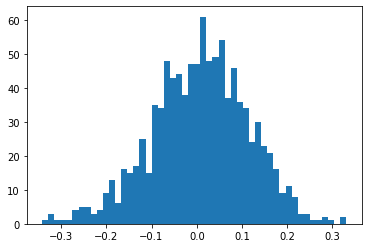

In [43]:
plt.hist(data2, bins=50)

(array([ 4.,  8., 11., 13., 18., 26., 24., 34., 34., 36., 56., 49., 58.,
        47., 61., 53., 69., 75., 66., 37., 33., 36., 41., 30., 20., 14.,
        10., 10.,  8.,  1.,  5.,  2.,  0.,  3.,  1.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.]),
 array([-0.258772  , -0.24181128, -0.22485056, -0.20788984, -0.19092912,
        -0.1739684 , -0.15700768, -0.14004696, -0.12308624, -0.10612552,
        -0.0891648 , -0.07220408, -0.05524336, -0.03828264, -0.02132192,
        -0.0043612 ,  0.01259952,  0.02956024,  0.04652096,  0.06348168,
         0.0804424 ,  0.09740312,  0.11436384,  0.13132456,  0.14828528,
         0.165246  ,  0.18220672,  0.19916744,  0.21612816,  0.23308888,
         0.2500496 ,  0.26701032,  0.28397104,  0.30093176,  0.31789248,
         0.3348532 ,  0.35181392,  0.36877464,  0.38573536,  0.40269608,
         0.4196568 ,  0.43661752,  0.45357824,  0.47053896,  0.48749968,
         0.5044604 ,  0.52142112,  0.53838184,  0.55534256,

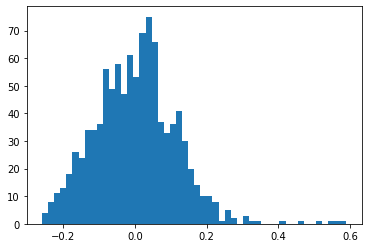

In [44]:
#plt.figure(figsize=(10,6))
plt.hist(data3, bins=50)

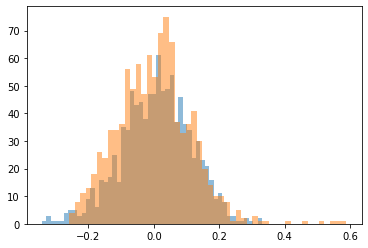

In [45]:
plt.hist(data2, bins=50, alpha=0.5)
plt.hist(data3, bins=50, alpha=0.5)
plt.show()

In [7]:
results_n_10 = np.zeros(200)
results_s_10 = np.zeros(200)

#n = 1000
#freq = np.linspace(25, 35, n)
#with open(f"{data_dir}/hist_tbank.csv", "w") as file:
    #for i in range(n):
        #file.write("{0} {1}\n".format(freq[i],0))

for i in range(200):
    generate_source(f"noise_{i}.csv", sigma=10, N=1000)
    File1 = prober(f"noise_{i}.csv", f=30, outputFile=f"results_noise_{i}_S1.csv", phi=0, mod=1)
    data4 = np.loadtxt(os.path.join(data_dir, File1))
    results_n_10[i] = data4[2]    
    generate_source(f"signal_{i}.csv", sigma=10, A=2, f=30, N=1000)
    File2 = prober(f"signal_{i}.csv", f=30, outputFile=f"results_signal_{i}_S1.csv", phi=0, mod=1)
    data5 = np.loadtxt(os.path.join(data_dir, File2))
    results_s_10[i] = data5[2]

The process has an output: 30 0 0.192599

The process has an output: 30 0 1.26722

The process has an output: 30 0 0.131096

The process has an output: 30 0 1.12324

The process has an output: 30 0 -0.116538

The process has an output: 30 0 0.977201

The process has an output: 30 0 -0.0983464

The process has an output: 30 0 1.35125

The process has an output: 30 0 0.204891

The process has an output: 30 0 1.02181

The process has an output: 30 0 0.133185

The process has an output: 30 0 0.583012

The process has an output: 30 0 -0.136943

The process has an output: 30 0 1.05843

The process has an output: 30 0 -0.114213

The process has an output: 30 0 0.960431

The process has an output: 30 0 -0.0514145

The process has an output: 30 0 0.820137

The process has an output: 30 0 0.0856342

The process has an output: 30 0 1.04851

The process has an output: 30 0 0.110478

The process has an output: 30 0 0.681638

The process has an output: 30 0 -0.371456

The process has an output: 30 0

The process has an output: 30 0 -0.0611987

The process has an output: 30 0 0.930844

The process has an output: 30 0 -0.0711043

The process has an output: 30 0 0.366373

The process has an output: 30 0 -0.0648503

The process has an output: 30 0 1.32558

The process has an output: 30 0 -0.195283

The process has an output: 30 0 0.727196

The process has an output: 30 0 0.0967335

The process has an output: 30 0 1.11504

The process has an output: 30 0 0.182158

The process has an output: 30 0 1.05216

The process has an output: 30 0 0.00545697

The process has an output: 30 0 0.936694

The process has an output: 30 0 -0.196903

The process has an output: 30 0 0.867632

The process has an output: 30 0 -0.21557

The process has an output: 30 0 0.656172

The process has an output: 30 0 0.0531779

The process has an output: 30 0 0.577439

The process has an output: 30 0 -0.0579984

The process has an output: 30 0 1.03551

The process has an output: 30 0 0.0455446

The process has an outp

The process has an output: 30 0 -0.2143

The process has an output: 30 0 1.01934

The process has an output: 30 0 0.0769877

The process has an output: 30 0 1.18264



(array([ 1.,  0.,  1.,  0.,  0.,  0.,  2.,  4.,  1.,  2.,  2.,  4.,  3.,
         1.,  6.,  3.,  2.,  5., 12.,  9.,  9.,  4., 10.,  5.,  4., 12.,
         9., 11.,  4., 10.,  6.,  6.,  5.,  9.,  6.,  6.,  3.,  6.,  6.,
         2.,  3.,  2.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([-7.1230700e-01, -6.8492966e-01, -6.5755232e-01, -6.3017498e-01,
        -6.0279764e-01, -5.7542030e-01, -5.4804296e-01, -5.2066562e-01,
        -4.9328828e-01, -4.6591094e-01, -4.3853360e-01, -4.1115626e-01,
        -3.8377892e-01, -3.5640158e-01, -3.2902424e-01, -3.0164690e-01,
        -2.7426956e-01, -2.4689222e-01, -2.1951488e-01, -1.9213754e-01,
        -1.6476020e-01, -1.3738286e-01, -1.1000552e-01, -8.2628180e-02,
        -5.5250840e-02, -2.7873500e-02, -4.9616000e-04,  2.6881180e-02,
         5.4258520e-02,  8.1635860e-02,  1.0901320e-01,  1.3639054e-01,
         1.6376788e-01,  1.9114522e-01,  2.1852256e-01,  2.4589990e-01,
         2.7327724e-01,  3.0065458e-01,  3.2803192e-01,  3.5540926e-

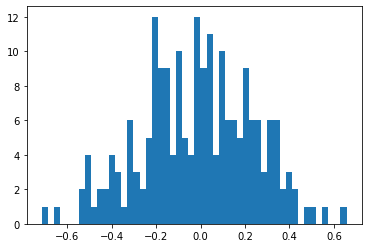

In [47]:
plt.hist(results_n_10, bins=50)

(array([ 1.,  0.,  0.,  1.,  0.,  2.,  3.,  0.,  1.,  5.,  4.,  6.,  5.,
         7.,  3.,  3.,  9.,  2.,  6., 10.,  8., 14., 14., 15.,  9., 13.,
         8.,  8., 10.,  8.,  6.,  6.,  5.,  3.,  0.,  1.,  2.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.296756  , 0.32840628, 0.36005656, 0.39170684, 0.42335712,
        0.4550074 , 0.48665768, 0.51830796, 0.54995824, 0.58160852,
        0.6132588 , 0.64490908, 0.67655936, 0.70820964, 0.73985992,
        0.7715102 , 0.80316048, 0.83481076, 0.86646104, 0.89811132,
        0.9297616 , 0.96141188, 0.99306216, 1.02471244, 1.05636272,
        1.088013  , 1.11966328, 1.15131356, 1.18296384, 1.21461412,
        1.2462644 , 1.27791468, 1.30956496, 1.34121524, 1.37286552,
        1.4045158 , 1.43616608, 1.46781636, 1.49946664, 1.53111692,
        1.5627672 , 1.59441748, 1.62606776, 1.65771804, 1.68936832,
        1.7210186 , 1.75266888, 1.78431916, 1.81596944, 1.84761972,
        1.87927   ]),
 <a list of 50

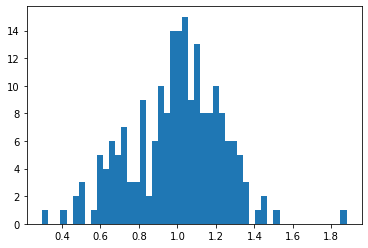

In [48]:
plt.hist(results_s_10, bins=50)

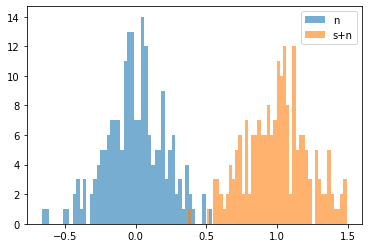

In [8]:
plt.hist(results_n_10, bins=50, alpha=0.6, label="n")
plt.hist(results_s_10, bins=50, alpha=0.6, label = "s+n")
plt.legend()
plt.show()
plt.close()

In [9]:
results_n_20 = np.zeros(200)
results_s_20 = np.zeros(200)

#n = 1000
#freq = np.linspace(25, 35, n)
#with open(f"{data_dir}/hist_tbank.csv", "w") as file:
    #for i in range(n):
        #file.write("{0} {1}\n".format(freq[i],0))

for i in range(200):
    generate_source(f"noise_{i}.csv", sigma=20, N=1000)
    File3 = prober(f"noise_{i}.csv", f=30, outputFile=f"results_noise_{i}_S1.csv", phi=0, mod=1)
    data6 = np.loadtxt(os.path.join(data_dir, File3))
    results_n_20[i] = data6[2]    
    generate_source(f"signal_{i}.csv", sigma=20, A=2, f=30, N=1000)
    File4 = prober(f"signal_{i}.csv", f=30, outputFile=f"results_signal_{i}_S1.csv", phi=0, mod=1)
    data7 = np.loadtxt(os.path.join(data_dir, File4))
    results_s_20[i] = data7[2] 

The process has an output: 30 0 -0.165501

The process has an output: 30 0 1.07573

The process has an output: 30 0 0.452833

The process has an output: 30 0 0.420666

The process has an output: 30 0 -0.417708

The process has an output: 30 0 1.11903

The process has an output: 30 0 -1.04315

The process has an output: 30 0 0.955711

The process has an output: 30 0 -0.385656

The process has an output: 30 0 1.9162

The process has an output: 30 0 -0.0351716

The process has an output: 30 0 1.66332

The process has an output: 30 0 1.37744

The process has an output: 30 0 1.43055

The process has an output: 30 0 -0.0272851

The process has an output: 30 0 0.829021

The process has an output: 30 0 0.459041

The process has an output: 30 0 0.835314

The process has an output: 30 0 0.540865

The process has an output: 30 0 1.37787

The process has an output: 30 0 -0.100631

The process has an output: 30 0 1.28362

The process has an output: 30 0 -0.73565

The process has an output: 30 0 0.5

The process has an output: 30 0 -0.0662616

The process has an output: 30 0 0.27661

The process has an output: 30 0 0.126202

The process has an output: 30 0 1.51695

The process has an output: 30 0 -0.625398

The process has an output: 30 0 0.982909

The process has an output: 30 0 0.100407

The process has an output: 30 0 1.58343

The process has an output: 30 0 0.0903952

The process has an output: 30 0 0.972157

The process has an output: 30 0 0.757246

The process has an output: 30 0 0.127372

The process has an output: 30 0 -0.381172

The process has an output: 30 0 0.749844

The process has an output: 30 0 -0.166396

The process has an output: 30 0 0.845362

The process has an output: 30 0 -0.358699

The process has an output: 30 0 1.56869

The process has an output: 30 0 0.269556

The process has an output: 30 0 0.584989

The process has an output: 30 0 0.237263

The process has an output: 30 0 0.922313

The process has an output: 30 0 -0.154408

The process has an output: 30 

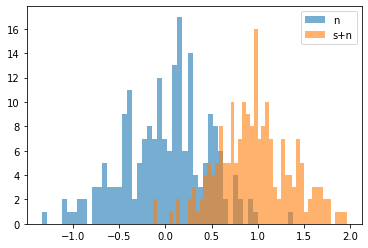

In [10]:
plt.hist(results_n_20, bins=50, alpha=0.6, label="n")
plt.hist(results_s_20, bins=50, alpha=0.6, label = "s+n")
plt.legend()
plt.show()
plt.close()

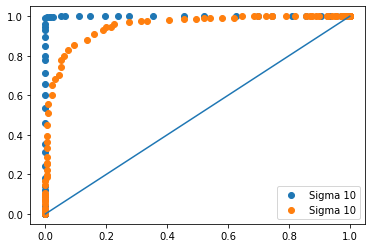

In [11]:
FP_10 = []
TP_10 = []
FP_20 = []
TP_20 = []

for t in np.linspace(-2,2,100):
    FP_10 = np.append(FP_10,len(np.where(results_n_10 >= t)[0])/len(results_n_10))
    TP_10 = np.append(TP_10,len(np.where(results_s_10 >= t)[0])/len(results_s_10))
    FP_20 = np.append(FP_20,len(np.where(results_n_20 >= t)[0])/len(results_n_20))
    TP_20 = np.append(TP_20,len(np.where(results_s_20 >= t)[0])/len(results_s_20))
    
plt.scatter(FP_10,TP_10,label="Sigma 10")
plt.scatter(FP_20,TP_20,label="Sigma 10")
plt.legend(loc="lower right")
plt.plot([0,1])
plt.show()
plt.close()

In [63]:
results_n_25 = np.zeros(100)
results_s_25 = np.zeros(100)

#n = 1000
#freq = np.linspace(25, 35, n)
#with open(f"{data_dir}/hist_tbank.csv", "w") as file:
    #for i in range(n):
        #file.write("{0} {1}\n".format(freq[i],0))
        
nfrq = 500
nphi = 50
frq = np.linspace(0.01, 1000.0, nfrq)
phi = np.linspace(0, 2*np.pi, nphi)
#frq = 10
#phi = 0

with open(f"{data_dir}/rand_tbank.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq[i], phi[j]))


"""
with open(f"{data_dir}/temp_bank_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq[i], phi[j]))
"""


for i in range(100):
    print(i)
    generate_source(f"noise_{i}.csv", sigma=25, N=1000)
    File5 = prober(f"noise_{i}.csv", outputFile=f"results_noise_{i}_rand.csv", template=f"rand_tbank.csv", mod=1)  
    #data8 = np.loadtxt(os.path.join(data_dir, f"results_noise_{i}_rand.csv")) 
    #results_n_25[i] = data8[2]
    generate_source(f"signal_{i}.csv", sigma=25, A=2, N=1000, r=1)
    prober(f"signal_{i}.csv", outputFile=f"results_signal_{i}_rand.csv", template=f"rand_tbank.csv", mod=1)
    #data9 = np.loadtxt(os.path.join(data_dir, f"results_signal_{i}_rand.csv"))
    #results_s_25[i] = data9[2]

0
The process has an output: 933.155963
5.863150

1
The process has an output: 365.366062
2.295264

2
The process has an output: 513.701794
3.227378

3
The process has an output: 172.006981
1.080231

4
The process has an output: 960.988966
6.038047

5
The process has an output: 751.363884
4.720802

6
The process has an output: 684.127092
4.298299

7
The process has an output: 475.897693
2.989824

8
The process has an output: 623.413734
3.916787

9
The process has an output: 559.221839
3.513417

10
The process has an output: 492.767994
3.095834

11
The process has an output: 424.418018
2.666335

12
The process has an output: 861.083870
5.410262

13
The process has an output: 792.698850
4.980544

14
The process has an output: 872.264762
5.480521

15
The process has an output: 804.212362
5.052892

16
The process has an output: 732.009391
4.599182

17
The process has an output: 170.290554
1.069446

18
The process has an output: 108.697094
0.682404

19
The process has an output: 41.216786
0

In [64]:
results_n_25 = []
results_s_25 = []

for i in range(100):
    print(i)
    data8 = np.loadtxt(os.path.join(data_dir, f"results_noise_{i}_rand.csv"))  
    data9 = np.loadtxt(os.path.join(data_dir, f"results_signal_{i}_rand.csv"))
    for j in range(25000):
        results_n_25 = np.append(results_n_25,data8[j][2])
        results_s_25 = np.append(results_s_25,data9[j][2])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


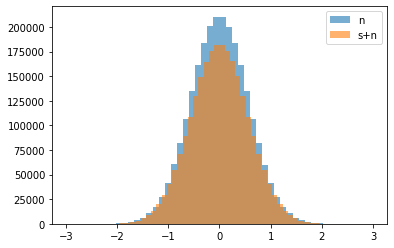

In [65]:
plt.hist(results_n_25, bins=50, alpha=0.6, label="n")
plt.hist(results_s_25, bins=50, alpha=0.6, label = "s+n")
plt.legend()
plt.show()
plt.close()

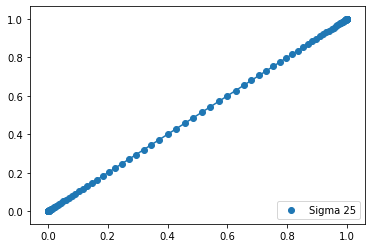

In [66]:
FP_25 = []
TP_25 = []

for t in np.linspace(-2,2,100):
    FP_25 = np.append(FP_25,len(np.where(results_n_25 >= t)[0])/len(results_n_25))
    TP_25 = np.append(TP_25,len(np.where(results_s_25 >= t)[0])/len(results_s_25))

plt.scatter(FP_25,TP_25,label="Sigma 25")
plt.legend(loc="lower right")
plt.plot([0,1])
plt.show()
plt.close()

In [67]:
def find_parameter(inFile,outFile,tbank,t,mode):
    prober(inputFile=inFile, outputFile=outFile, template=tbank, mod=mode)
    data = np.loadtxt(os.path.join(data_dir, outFile))
    
    if mode == 2:
        best = np.where(data[:,2] == np.min(data[:,2]))
        print("Minimum value is at f = {0:.3f}Hz".format(data[:,0][best][0]))
        print("Minimum value is at phi = {0:.3f}".format(data[:,1][best][0]))
        print("Minimum Value       = {0:.3f} ({0:.8f})".format(data[:,2][best][0]))
    else:
        best = np.where(data[:,2] == np.max(data[:,2]))
        s = data[:,2]
        s_best = data[:,2][best][0]
        if s_best >= t:
            print("Signal is detected")
            print("Signal is present at f = {0:.3f}Hz".format(data[:,0][best][0]))
            print("Signal is present at p = {0:.3f}".format(data[:,1][best][0]))
            print("Maximum Value       = {0:.3f} ({0:.8f})".format(data[:,2][best][0]))
            print("The value of S is >= the threshold",len(np.where(s >= t)[0]),"times.")
            print(data[np.where(s >= t)[0]][:,2])
            print("\n")
            result = "positive"
        elif s_best < t:
            print("Signal is not detected")
            print("Maximum is at f = {0:.3f}Hz".format(data[:,0][best][0]))
            print("Maximum is at p = {0:.3f}".format(data[:,1][best][0]))
            print("Maximum Value       = {0:.3f} ({0:.8f})".format(data[:,2][best][0]))
            print("\n")
            result = "negative"
            
    return result, s_best

In [68]:
s_list_signal = []
s_all_signal = []

number_of_files = 0

nfrq = 500
nphi = 50
frq = np.linspace(0.01, 1000.0, nfrq)
phi = np.linspace(0, 2*np.pi, nphi)

with open(f"{data_dir}/temp_bank_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq[i], phi[j]))

for i in range(50):
    generate_source(f"data_signal_{i}.csv", sigma=10, A=2, N=1000, r=1)
    time.sleep(1)
    result, s_value = find_parameter(inFile=f"data_signal_{i}.csv", outFile=f"result_signal_{i}.csv", tbank=f"temp_bank_{nfrq}_{nphi}.csv", mode=1, t=0.9)
    if result == "positive":
        s_list_signal = np.append(s_list_signal,s_value)
        number_of_files = number_of_files + 1
    s_all_signal = np.append(s_all_signal,s_value)

print(s_list_signal)
print("Number of files where a signal is present:",number_of_files)

The process has an output: 520.843921
3.272258

Signal is not detected
Maximum is at f = 370.748Hz
Maximum is at p = 0.898
Maximum Value       = 0.713 (0.71268800)


The process has an output: 458.322011
2.879382

Signal is not detected
Maximum is at f = 825.653Hz
Maximum is at p = 0.256
Maximum Value       = 0.716 (0.71606000)


The process has an output: 887.901371
5.578778

Signal is detected
Signal is present at f = 887.777Hz
Signal is present at p = 6.027
Maximum Value       = 1.163 (1.16259000)


The process has an output: 821.419933
5.161021

Signal is detected
Signal is present at f = 178.365Hz
Signal is present at p = 4.488
Maximum Value       = 0.968 (0.96811700)


The process has an output: 252.166556
1.583939

Signal is detected
Signal is present at f = 545.095Hz
Signal is present at p = 4.103
Maximum Value       = 0.963 (0.96255900)


The process has an output: 543.901699
3.417149

Signal is not detected
Maximum is at f = 94.197Hz
Maximum is at p = 6.155
Maximum Value     

Signal is not detected
Maximum is at f = 947.896Hz
Maximum is at p = 6.027
Maximum Value       = 0.771 (0.77143600)


[1.16259  0.968117 0.962559 0.967672 0.988563 1.25744  1.04886  0.979682
 0.905792 1.00749  0.949923 0.941097 0.994632 0.972585]
Number of files where a signal is present: 14


In [69]:
s_list_noise = []
s_all_noise = []

numebr_of_files = 0

nfrq = 500
nphi = 50
frq = np.linspace(0.01, 1000.0, nfrq)
phi = np.linspace(0, 2*np.pi, nphi)

with open(f"{data_dir}/temp_bank_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq[i], phi[j]))

for i in range(50):
    generate_source(f"data_noise_{i}.csv", sigma=10, A=0, N=1000)
    #time.sleep(1)
    result, s_value = find_parameter(inFile=f"data_noise_{i}.csv", outFile=f"result_noise_{i}.csv", tbank=f"temp_bank_{nfrq}_{nphi}.csv", mode=1, t=0.9)
    if result == "positive":
        s_list_noise = np.append(s_list_noise,s_value)
        number_of_files = number_of_files + 1
    s_all_noise = np.append(s_all_noise,s_value)

print(s_list_noise)
print("Number of files where a signal is present:",number_of_files)

Signal is not detected
Maximum is at f = 525.055Hz
Maximum is at p = 1.795
Maximum Value       = 0.882 (0.88248800)


Signal is not detected
Maximum is at f = 346.700Hz
Maximum is at p = 0.000
Maximum Value       = 0.784 (0.78437500)


Signal is not detected
Maximum is at f = 981.964Hz
Maximum is at p = 4.616
Maximum Value       = 0.860 (0.86019300)


Signal is not detected
Maximum is at f = 939.880Hz
Maximum is at p = 2.821
Maximum Value       = 0.753 (0.75312000)


Signal is not detected
Maximum is at f = 370.748Hz
Maximum is at p = 0.769
Maximum Value       = 0.845 (0.84528800)


Signal is not detected
Maximum is at f = 819.641Hz
Maximum is at p = 6.155
Maximum Value       = 0.684 (0.68408500)


Signal is not detected
Maximum is at f = 394.796Hz
Maximum is at p = 1.667
Maximum Value       = 0.736 (0.73615400)


Signal is not detected
Maximum is at f = 609.222Hz
Maximum is at p = 1.923
Maximum Value       = 0.788 (0.78815200)


Signal is not detected
Maximum is at f = 436.879Hz
Maxim

In [ ]:
plt.hist(s_all_noise, bins="auto", alpha=0.6, label="n")
plt.hist(s_all_signal, bins="auto", alpha=0.6, label = "s+n")
plt.legend()
plt.show()
plt.close()

In [ ]:
FP_10_rand = []
TP_10_rand = []
#t = 0.9


for t in np.linspace(-2,2,100):
    FP_10_rand = np.append(FP_10_rand,len(np.where(s_all_noise >= t)[0])/len(s_all_noise))
    TP_10_rand = np.append(TP_10_rand,len(np.where(s_all_signal >= t)[0])/len(s_all_signal))



#FP_10_rand = np.append(FP_10_rand,len(np.where(s_all_noise >= t)[0])/len(s_all_noise))
#TP_10_rand = np.append(TP_10_rand,len(np.where(s_all_signal >= t)[0])/len(s_all_signal))

    
plt.scatter(FP_10_rand,TP_10_rand,label="Sigma 10")
plt.legend(loc="lower right")
plt.plot([0,1])
plt.show()
plt.close()